# 数据预处理

## 数据读取

In [1]:
def read_data(path):
    # 读取train.txt格式的数据，返回字典
    data = {}
    with open(path, 'r') as f:
        while True:
            line = f.readline().strip()
            if not line:  # EOF
                break
            # 读取user_id和rate_num
            user_id, rate_num = line.split('|')
            rate_num = int(rate_num)
            user_id = int(user_id)
            # 读取用户的评分数据
            rate_data = {}
            for i in range(rate_num):
                item_id, score = f.readline().strip().split()
                item_id = int(item_id)
                score = int(score)
                rate_data[item_id] = score
            # 保存该用户的数据
            data[user_id] = rate_data
    return data

In [2]:
PATH = 'data/train.txt'
data = read_data(PATH)

## 数据分析

### 统计用户和商品的id情况

In [3]:
user_set = set()  # 所有用户的集合
item_set = set()  # 所有物品的集合
rating_count = 0  # 记录所有用户评分的次数
score_map = {}  # 每个评分的次数统计

for user_id, rate_data in data.items():  # 遍历所有用户
    user_set.add(user_id)
    for item_id, score in rate_data.items():  # 遍历用户的评分
        item_set.add(item_id)
        rating_count += 1
        if score in score_map:
            score_map[score] += 1
        else:
            score_map[score] = 1

print('用户数：', len(user_set))
print('物品数：', len(item_set))
print('累积评分次数：', rating_count)

用户数： 19835
物品数： 455691
累积评分次数： 5001507


### 统计数据分布情况

In [4]:
max_user_id = max(user_set)
max_item_id = max(item_set)
min_user_id = min(user_set)
min_item_id = min(item_set)
print('最大用户id：', max_user_id)
print('最小用户id：', min_user_id)
print('最大物品id：', max_item_id)
print('最小物品id：', min_item_id)
print('用户id是否连续：', len(user_set) == int(max_user_id) - int(min_user_id) + 1)
print('物品id是否连续：', len(item_set) == int(max_item_id) - int(min_item_id) + 1)

最大用户id： 19834
最小用户id： 0
最大物品id： 624960
最小物品id： 0
用户id是否连续： True
物品id是否连续： False


In [5]:
# 统计次数最多的评分
max_score = max(score_map.items(), key=lambda x: x[1])
min_score = min(score_map.items(), key=lambda x: x[1])
print('最多的评分：', max_score)
print('最少的评分：', min_score)
print('评分种类：', len(score_map))
average_score = rating_count / len(score_map)
print('每个评分的平均次数：', average_score)

最多的评分： (0, 1535563)
最少的评分： (7, 247)
评分种类： 101
每个评分的平均次数： 49519.87128712871


In [6]:
# 绘制得分-次数 散点图
import matplotlib.pyplot as plt

def draw_scatter(x, y, xlabel, ylabel, title):
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

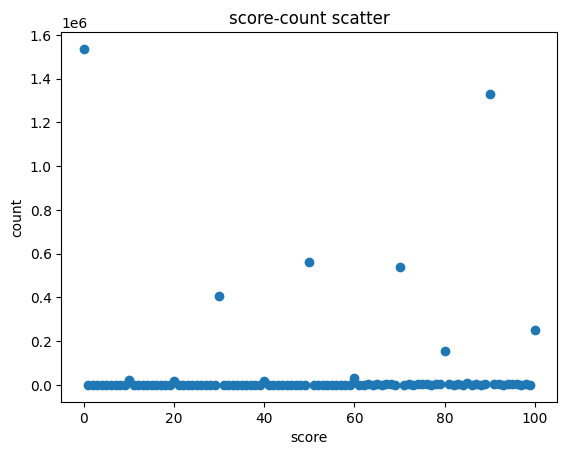

In [7]:
x = list(score_map.keys())
y = list(score_map.values())
draw_scatter(x, y, 'score', 'count', 'score-count scatter')

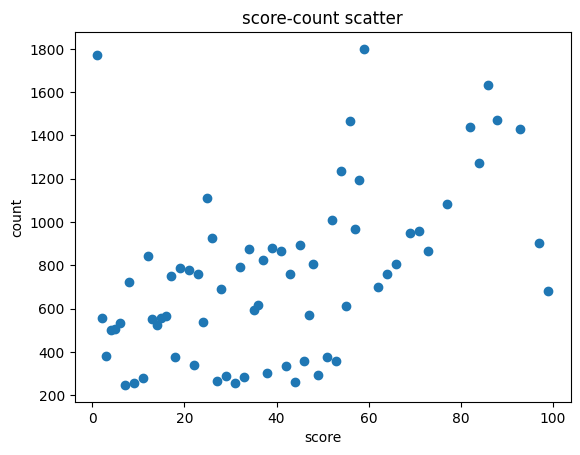

In [8]:
# 剔除掉次数超过2000的评分
clean_score_map = {k: v for k, v in score_map.items() if v < 2000}
x = list(clean_score_map.keys())
y = list(clean_score_map.values())
draw_scatter(x, y, 'score', 'count', 'score-count scatter')

### 统计均值与偏差

In [9]:
# 全局平均评分
total_score = 0
for score, count in score_map.items():
    total_score += score * count
average_score = total_score / rating_count
print('全局平均评分：', average_score)

全局平均评分： 49.50627100991761


In [10]:
def cal_user_bias(data, average_score):
    # 统计每个用户的平均打分
    user_average_score = {}
    for user_id, rate_data in data.items():
        total_score = 0
        for score in rate_data.values():
            total_score += score
        user_average_score[user_id] = total_score / len(rate_data)
    # 每个用户与全局平均评分的偏差
    user_bias = {}
    for user_id, u_ave_score in user_average_score.items():
        user_bias[user_id] = u_ave_score - average_score
    # 最小偏差，最大偏差，平均偏差
    max_bias = max(user_bias.items(), key=lambda x: x[1])
    min_bias = min(user_bias.items(), key=lambda x: x[1])
    total_bias = 0
    for bias in user_bias.values():
        total_bias += bias
    average_bias = total_bias / len(user_bias)
    return user_average_score, user_bias, max_bias, min_bias, average_bias

In [11]:
user_average_score, user_bias, max_bias, min_bias, average_bias = cal_user_bias(data, average_score)
print('最大偏差：', max_bias)
print('最小偏差：', min_bias)
print('平均偏差：', average_bias)

最大偏差： (547, 50.49372899008239)
最小偏差： (413, -49.50627100991761)
平均偏差： 20.32124186733326


In [13]:
def cal_item_bias(data, average_score):
    # 统计物品得分
    item_scores = {}
    for user_id, rate_data in data.items():
        for item_id, score in rate_data.items():
            if item_id in item_scores:
                item_scores[item_id].append(score)
            else:
                item_scores[item_id] = [score]
    # 计算物品平均得分
    item_average_score = {}
    for item_id, scores in item_scores.items():
        item_average_score[item_id] = sum(scores) / len(scores)
    # 计算物品偏差
    item_bias = {}
    for item_id, i_ave_score in item_average_score.items():
        item_bias[item_id] = i_ave_score - average_score
    # 最大偏差，最小偏差，平均偏差
    max_bias = max(item_bias.items(), key=lambda x: x[1])
    min_bias = min(item_bias.items(), key=lambda x: x[1])
    total_bias = 0
    for bias in item_bias.values():
        total_bias += bias
    average_bias = total_bias / len(item_bias)
    return item_average_score, item_bias, max_bias, min_bias, average_bias

In [14]:
item_average_score, item_bias, max_bias, min_bias, average_bias = cal_item_bias(data, average_score)
print('最大偏差：', max_bias)
print('最小偏差：', min_bias)
print('平均偏差：', average_bias)

最大偏差： (342087, 50.49372899008239)
最小偏差： (536256, -49.50627100991761)
平均偏差： -5.746944408888505


## 训练集和验证集划分

In [15]:
import random

random.seed(0)
def split_data(data, ratio=0.8, shuffle=True):
    # 将数据集划分为训练集和测试集
    train_data = {}
    validate_data = {}
    for user_id, rate_data in data.items():
        items = list(rate_data.keys())
        if shuffle:
            random.shuffle(items)
        train_data[user_id] = {}
        validate_data[user_id] = {}
        for i in range(int(len(items) * ratio)):
            item_id = items[i]
            train_data[user_id][item_id] = rate_data[item_id]
        for i in range(int(len(items) * ratio), len(items)):
            item_id = items[i]
            validate_data[user_id][item_id] = rate_data[item_id]
    return train_data, validate_data

In [16]:
train_data, validate_data = split_data(data)
print('train_data:', len(train_data))
print('validate_data:', len(validate_data))
print(len(train_data) == len(validate_data) == len(data))
print((len(train_data[0]) + len(validate_data[0])) == len(data[0]))
print(len(train_data[0]) / len(data[0]))

train_data: 19835
validate_data: 19835
True
True
0.7804878048780488


In [17]:
def write_data(data, path):
    # 将数据写入文件
    with open(path, 'w') as f:
        for user_id, rate_data in data.items():
            f.write(f'{user_id}|{len(rate_data)}\n')
            for item_id, score in rate_data.items():
                f.write(f'{item_id} {score}\n')

In [18]:
PATH_train = 'data/train_data.txt'
PATH_validate = 'data/validate_data.txt'
write_data(train_data, PATH_train)
write_data(validate_data, PATH_validate)

In [19]:
def read_test_data(path):
    # 读取test.txt格式的数据，返回字典
    data = {}
    with open(path, 'r') as f:
        while True:
            line = f.readline().strip()
            if not line:  # EOF
                break
            # 读取user_id和rate_num
            user_id, rate_num = line.split('|')
            rate_num = int(rate_num)
            user_id = int(user_id)
            # 读取用户的评分数据
            rate_data = []
            for i in range(rate_num):
                item_id= f.readline().strip()
                item_id = int(item_id)
                rate_data.append(item_id)
            # 保存该用户的数据
            data[user_id] = rate_data
    return data

test_data_path='data/test.txt'
test_data=read_test_data(test_data_path)

In [20]:
# 检查test的数据是否在train或valid里出现过
def check_test_data(test_data, train_data, validate_data):
    all_item=set()
    num=0
    for user_id, rate_data in train_data.items():
        all_item.update(rate_data.keys())
    train_max=max(all_item)
    for user_id, rate_data in validate_data.items():
        all_item.update(rate_data.keys())
    train_validate_max=max(all_item)
    print('train_max_id:', train_max)
    print('train_validate_max_id:', train_validate_max)
    for user_id, rate_data in test_data.items():
        for item_id in rate_data:
            if item_id not in all_item:
                # print('item_id not in train:', item_id)
                if item_id>=train_validate_max:
                    print('item_id>max_id:', item_id,max)
                num+=1
    
    return num

absent_count=check_test_data(test_data, train_data, validate_data)
print('absent_count:',absent_count)


train_max_id: 624960
train_validate_max_id: 624960
absent_count: 1040


## attribute数据处理

In [1]:
def read_attribute_data(path):
    # 读取item_attribute.txt格式的数据，返回字典
    attrs_data = {}
    with open(path, 'r') as f:
        while True:
            line = f.readline().strip()
            if not line:
                break
            item_id, attr1, attr2 = line.strip().split('|')
            item_id = int(item_id)
            attr1 = 0 if attr1 == 'None' else int(attr1)
            attr2 = 0 if attr2 == 'None' else int(attr2)
            attrs_data[item_id] = (attr1, attr2)
    return attrs_data            

In [2]:
attrs_data_path = 'data/itemAttribute.txt'
attrs_data = read_attribute_data(attrs_data_path)
print('attrs_data:', len(attrs_data))

attrs_data: 507172


In [3]:
def process_attrs(attrs_data):
    # 统计属性1相同的item集，属性2相同的item集，属性1和属性2都相同的item集
    attr1_map = {}
    attr2_map = {}
    attr1_attr2_map = {}
    for item_id, (attr1, attr2) in attrs_data.items():
        if attr1 in attr1_map and attr1 != 0:
            attr1_map[attr1].append(item_id)
        else:
            attr1_map[attr1] = [item_id]
        if attr2 in attr2_map and attr2 != 0:
            attr2_map[attr2].append(item_id)
        else:
            attr2_map[attr2] = [item_id]
        if (attr1, attr2) in attr1_attr2_map and attr1 != 0 and attr2 != 0:
            attr1_attr2_map[(attr1, attr2)].append(item_id)
        else:
            attr1_attr2_map[(attr1, attr2)] = [item_id]
    return attr1_map, attr2_map, attr1_attr2_map

In [4]:
attr1_map, attr2_map, attr1_attr2_map = process_attrs(attrs_data)
print('attr1_map:', len(attr1_map))
print('attr2_map:', len(attr2_map))
print('attr1_attr2_map:', len(attr1_attr2_map))

attr1_map: 52188
attr2_map: 19692
attr1_attr2_map: 75985


In [5]:
clean_attr1_map = {k: v for k, v in attr1_map.items() if len(v) >= 2}
print('clean_attr1_map:', len(clean_attr1_map))
clean_attr2_map = {k: v for k, v in attr2_map.items() if len(v) >= 2}
print('clean_attr2_map:', len(clean_attr2_map))
clean_attr1_attr2_map = {k: v for k, v in attr1_attr2_map.items() if len(v) >= 2}
print('clean_attr1_attr2_map:', len(clean_attr1_attr2_map))

clean_attr1_map: 41242
clean_attr2_map: 14248
clean_attr1_attr2_map: 40579


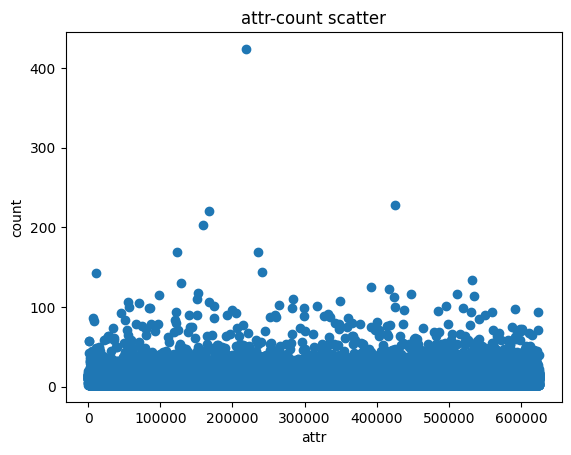

In [6]:
import matplotlib.pyplot as plt

def draw_attrs_scatter(x, y, xlabel, ylabel, title):
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

x = list(clean_attr1_map.keys())
y = [len(v) for v in clean_attr1_map.values()]
draw_attrs_scatter(x, y, 'attr', 'count', 'attr-count scatter')

In [7]:
import random
# 为每个节点选择k个与自己有相同属性的节点
def select_similar_nodes(attrs_data, attr1_map, attr2_map, attr1_attr2_map, k=10):
    similar_nodes = {}
    for item_id, (attr1, attr2) in attrs_data.items():
        similar_nodes[item_id] = set()
        # 优先从两个属性都相同的节点中选择
        if (attr1, attr2) in attr1_attr2_map:
            similar_nodes[item_id].update(attr1_attr2_map[(attr1, attr2)])
        if len(similar_nodes[item_id]) >= k:
            # 随机采样到k个节点
            similar_nodes[item_id] = random.sample(similar_nodes[item_id], k)
            continue
        # 从属性1相同和属性2相同的节点中选择试尽可能达到k个
        if attr1 in attr1_map:
            similar_nodes[item_id].update(attr1_map[attr1])
        if attr2 in attr2_map:
            similar_nodes[item_id].update(attr2_map[attr2])
        if len(similar_nodes[item_id]) >= k:
            similar_nodes[item_id] = random.sample(similar_nodes[item_id], k)               
    return similar_nodes

In [8]:
# 选择每个节点的k个相似节点
k = 10
similar_nodes = select_similar_nodes(attrs_data, attr1_map, attr2_map, attr1_attr2_map, k)
print('similar nodes for node 0:', similar_nodes[0])

C:\Users\jiang\AppData\Local\Temp\ipykernel_3972\784915914.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  similar_nodes[item_id] = random.sample(similar_nodes[item_id], k)
C:\Users\jiang\AppData\Local\Temp\ipykernel_3972\784915914.py:20: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  similar_nodes[item_id] = random.sample(similar_nodes[item_id], k)


similar nodes for node 0: [405085, 373452, 512783, 66012, 238077, 72576, 342922, 611272, 227008, 110783]


In [9]:
import pickle

# 保存相似节点数据
with open('data/similar_nodes.pkl', 'wb') as f:
    pickle.dump(similar_nodes, f)